# Battery Optimization

### 0.1 Imports of needed libraries  

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from copy import deepcopy

In [3]:
from battery_optimization.data_handler import DataHandler
from battery_optimization.battery_optimizer import Battery, BatteryOptimizer, PyoBatteryOptimizer

In [4]:
dh = DataHandler()
df_prices = dh.hourly_df
prices = df_prices['price'].to_numpy()

08-Oct-24 10:49:18 - Loading existing processed file: dayahead_hourly.feather
08-Oct-24 10:49:18 - Loading existing processed file: dayahead_fifteen.feather


## 1. Problem definition

### 1.1 Scipy implementation

Using the formulation of `scipy.optimize.linprog` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html), with linear programming we want to minimize a linear objective function subject to linear equality and inequality constraints.

In our case, we have a battery that can use the energy from the electricity grid to recharge ($P > 0.$) or can discharge ($P < 0.$) providing electricity back to the grid. The total cost or revenue of the single time interval $\Delta t$ is given by $c_i \cdot P_i \cdot \Delta t$, where $c_i$ is the price in €/MWh and $P_i$ is the average power of charge/discharge of the battery. The objective function that we want to minimize, in order to maximise the revenues, is:   

\begin{equation}
cost=\sum_{i=0}^{N} c_i P_i\Delta t
\end{equation}

The different constraints can be formalised as follows:
1. The power of charge/discharge is limited at all times $P_{min} \leq P_i \leq P_{max} \tag{1}$ with $P_{min} = -P_{max}$ in our formalism. 
2. The energy stored in the battery is limited at all times $0 \leq E_i \leq E_{max}$:
\begin{align}
E_i=\sum_{j=0}^i P_j \Delta t + E_0\\
\sum_{j=0}^i P_j \Delta t \leq E_{max} - E_0
\tag{2}
\end{align}

\begin{align}
- \sum_{j=0}^i P_j \Delta t \leq E_0
\tag{3}
\end{align}

The two inequalities can be expressed in matrix form with $T_{low}$ representing a low triangular matrix>

\begin{equation}
\left(
\begin{array}{c}
T_{low} \\
-T_{low}
\end{array}
\right)
\cdot P
\leq 
\left(\begin{array}{c}
E_{max} - E_0\\
E_0
\end{array}
\right)
\end{equation}

3. The final energy stored on the battery
\begin{equation}
E_{final} = \sum_{i=0}^N P_i \Delta t + E_0
\tag{4}
\end{equation}

### 1.2 Pyomo implementation

As a crosscheck, the problem has been implemented also using the pyomo (https://pyomo.readthedocs.io/en/stable/pyomo_overview/index.html) library. The definition of the problem remains the same, but there are some adjustments needed for the different infrastructure. The main difference will be the separation of the $P$ variable into a recharge $R$ and discharge $D$ variable, with $P = R - D$. 

## 2. Implementations

### 2.1 Parameters

In [5]:
dt = 1. #hours
E_0 = 0. #MWh
E_final = 0. #MWh
E_max = 1. #MWh
P_max = 1. #MW

#### 2.2 Battery Definition

In [6]:
bat = Battery(
    E_0=E_0,
    E_final=E_final,
    E_max=E_max,
    P_max=P_max,
    P_min=-P_max
)

#### 2.3 Optimization

2.3.1 Scipy implementation

In [7]:
scipy_profit, scipy_results = BatteryOptimizer(
    battery=bat,
    dt=dt,
    prices=prices,
).optimize()

08-Oct-24 10:49:36 - Optimization successful: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [8]:
print(f"Total Revenue {-1*scipy_profit:0.2f} €")

Total Revenue 38031.35 €


2.3.2 Pyomo implementation

In [9]:
pyomo_profit, pyomo_results = PyoBatteryOptimizer(
    battery=bat,
    dt=dt,
    prices=prices,
    fee=0.0
).optimize()

08-Oct-24 10:49:37 - Optimization successful: optimal


In [10]:
print(f"Total Revenue {-1*pyomo_profit:0.2f} €")

Total Revenue 38031.35 €


#### 2.4 Manual Strategy

In the case of not knowing the future prices, one of the easiest strategies to decide when to charge/discharge the battery is to use the min/max prices of the previous day. This is a naive approach, that can be improved by using more refined forecasting strategies, but can be used to evaluate the advantages of an optimization. The steps are as follows:
1) Find hour of the previous day in which the price was maximum and assign it as "Discharge"
2) Find hour of the previous day, earlier than the maximum, in which the price was minimum and assign it as "Recharge"

In [11]:
df_prices['shifted_price'] = df_prices.shift(24)['price']

In [12]:
stepsize = 24
n_steps = int(len(df_prices)/stepsize)

recharge = []
discharge = []
for i in range(n_steps):
    if i==0:
        recharge.append(np.zeros(24))
        discharge.append(np.zeros(24))
        continue
    day = deepcopy(df_prices[i*24:(i+1)*24]).sort_values(by="shifted_price").reset_index(drop=True)
    hour_max = day.iloc[23].hour
    day_before_max = day[day["hour"]<=hour_max]
    hour_min = day_before_max.iloc[day_before_max["shifted_price"].argmin()].hour
    day_recharge = np.zeros(24)
    day_recharge[hour_min] = 1.
    day_discharge = np.zeros(24)
    day_discharge[hour_max] = 1
    recharge.append(day_recharge)
    discharge.append(day_discharge)
recharge = np.array(recharge)
discharge = np.array(discharge)

In [13]:
power = recharge - discharge

In [14]:
df_prices["manual_strategy"] = power.flatten()

In [15]:
manual_profit = np.sum(df_prices['manual_strategy']*df_prices['price'])

In [16]:
print(f"Total Revenue {-1*manual_profit:0.2f} €")

Total Revenue 17267.12 €


## 3. Results

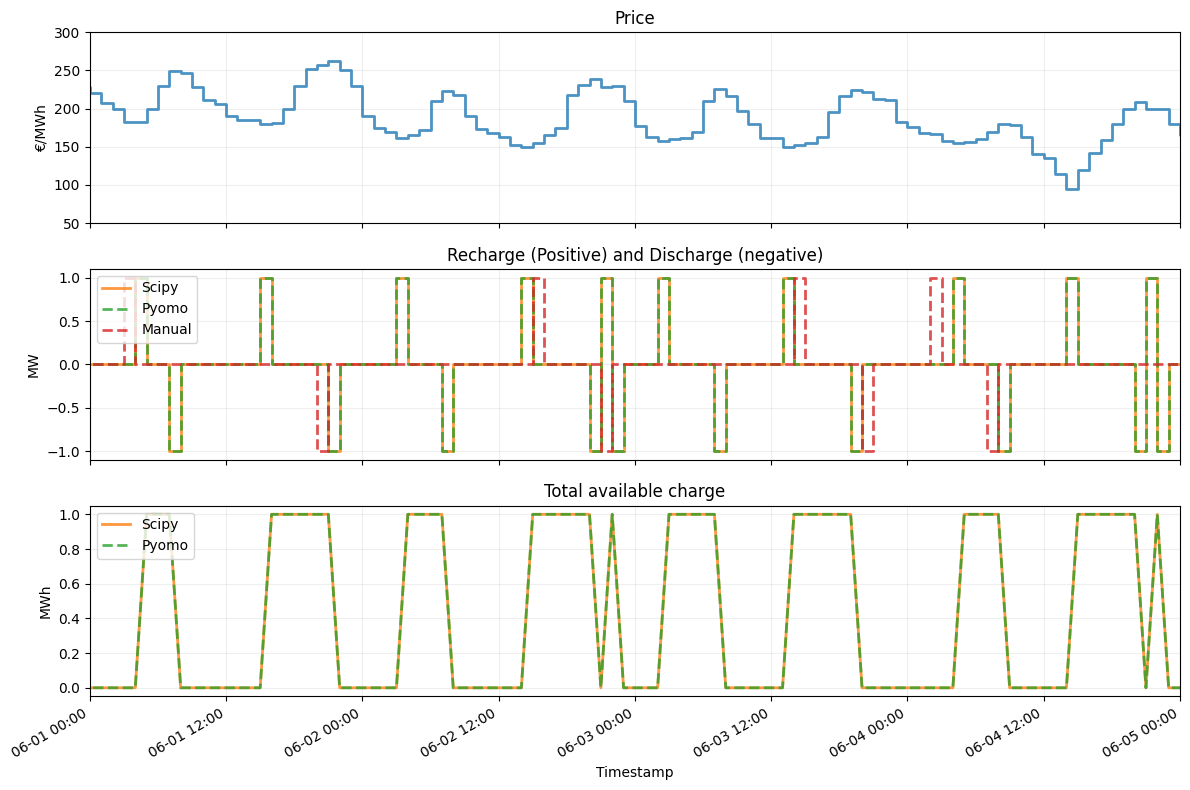

In [17]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(12,8))

sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y='price', 
    ax=ax[0], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Price",
    lw=2
)
ax[0].set_ylabel("€/MWh")
ax[0].set_title("Price")
ax[0].grid(alpha=0.2)
ax[0].set_ylim([50,300])

sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=scipy_results["power"], 
    ax=ax[1], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Scipy",
    color="C1",
    lw=2
)
sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=pyomo_results["power"], 
    ax=ax[1], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Pyomo",
    color="C2",
    ls="dashed",
    lw=2
)
sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y="manual_strategy", 
    ax=ax[1], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Manual",
    color="C3",
    ls="dashed",
    lw=2
)
ax[1].set_ylabel("MW")
ax[1].set_title("Recharge (Positive) and Discharge (negative)")
ax[1].grid(alpha=0.2)

sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=scipy_results["capacity"], 
    ax=ax[2], 
    alpha=0.8, 
    #drawstyle='steps-post', 
    label="Scipy",
    color="C1",
    lw=2
)
sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=pyomo_results["capacity"], 
    ax=ax[2], 
    alpha=0.8, 
    #drawstyle='steps-post', 
    label="Pyomo",
    color="C2",
    ls="dashed",
    lw=2
)
ax[2].set_ylabel("MWh")
ax[2].set_title("Total available charge")
ax[2].grid(alpha=0.2)

ax[0].set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-05 00:00"]))

ax[0].get_legend().remove()
ax[1].legend(loc="upper left")
ax[2].legend(loc="upper left")

date_formatter = mdates.DateFormatter('%m-%d %H:%M')
ax[2].xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()
ax[2].set_xlabel("Timestamp")

plt.tight_layout()

Most frequent times of recharge and discharge.

In [18]:
df_prices["power"] = pyomo_results["power"]

In [19]:
grouped_results = df_prices.groupby("power")
grouped_manual = df_prices.groupby("manual_strategy")

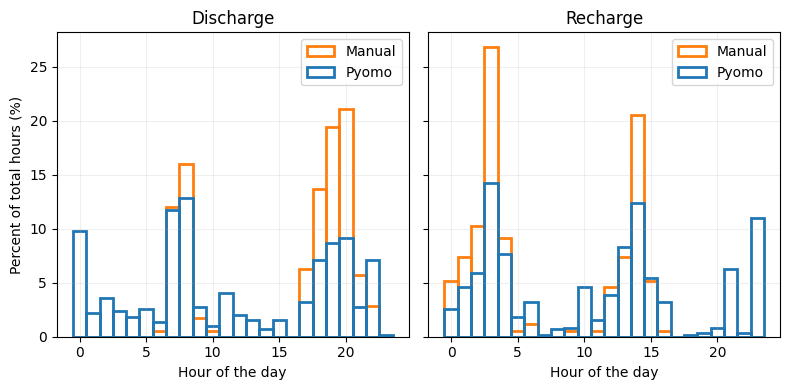

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)

for i, (proc,g) in enumerate({"Discharge": -1, "Recharge": 1}.items()):
    df = grouped_results.get_group(g)
    df_manual = grouped_manual.get_group(g)
    bins = np.linspace(-0.5,23.5,25)
    sns.histplot(df_manual['hour'], ax=ax[i], stat='percent', bins=bins, label="Manual", fill=False, linewidth=2, color="C1")
    sns.histplot(df['hour'], ax=ax[i], stat='percent', bins=bins, label="Pyomo", fill=False, linewidth=2, color="C0")
    ax[i].set_title(proc)
    ax[i].set_ylabel("Percent of total hours (%)")
    ax[i].set_xlabel("Hour of the day")
    ax[i].grid(alpha=0.2)
    ax[i].legend()
    
plt.tight_layout()

Text(0.5, 1.0, 'Calculated Revenues')

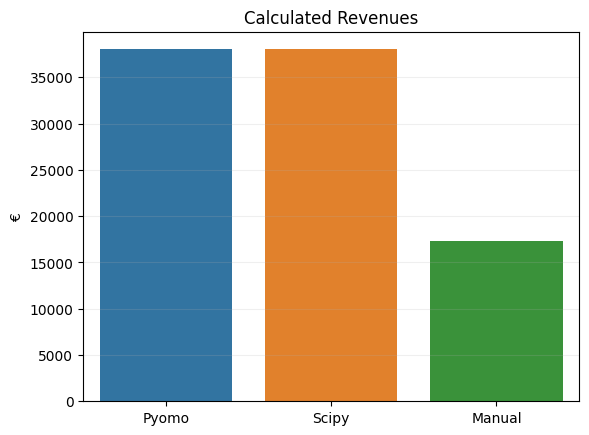

In [21]:
fig, ax = plt.subplots()
ax.grid(alpha=0.2)

sns.barplot(
    x=np.array(["Pyomo", "Scipy", "Manual"]), 
    y=-1*np.array([pyomo_profit, scipy_profit, manual_profit]),
    ax=ax
)

ax.set_ylabel("€")

ax.set_title("Calculated Revenues")